# Getting the required code and models

In [1]:
!git clone https://github.com/FreshMag/omr-img2midi.git
!mv /content/omr-img2midi/* /content/
!rm -rf omr-img2midi
!mkdir models
%cd models
!wget https://grfia.dlsi.ua.es/primus/models/PrIMuS/Semantic-Model.zip
!unzip Semantic-Model.zip -d semantic
!rm Semantic-Model.zip
%cd ..
!mkdir outputs

Cloning into 'omr-img2midi'...
remote: Enumerating objects: 231, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 231 (delta 76), reused 105 (delta 49), pack-reused 86
Receiving objects: 100% (231/231), 418.85 KiB | 5.30 MiB/s, done.
Resolving deltas: 100% (108/108), done.
/content/models
--2024-02-27 15:40:15--  https://grfia.dlsi.ua.es/primus/models/PrIMuS/Semantic-Model.zip
Resolving grfia.dlsi.ua.es (grfia.dlsi.ua.es)... 193.145.231.49
Connecting to grfia.dlsi.ua.es (grfia.dlsi.ua.es)|193.145.231.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190886707 (182M) [application/zip]
Saving to: ‘Semantic-Model.zip’

Semantic-Model.zip  100%[===================>] 182.04M  3.74MB/s    in 31s     

2024-02-27 15:40:46 (5.94 MB/s) - ‘Semantic-Model.zip’ saved [190886707/190886707]

Archive:  Semantic-Model.zip
  inflating: semantic/semantic_model.data-00000-of-00001  
  inflating: semantic/semant

# Getting the Java tools for conversion: `semantic → MIDI/MEI`

In [2]:
!wget https://grfia.dlsi.ua.es/primus/primus_converter.tgz
!tar xzvf primus_converter.tgz
!mv primus_conversor/omr-3.0-SNAPSHOT.jar ./converter/omr-3.0-SNAPSHOT.jar
!rm -rf ./primus_conversor
!rm ./primus_converter.tgz

--2024-02-27 15:40:50--  https://grfia.dlsi.ua.es/primus/primus_converter.tgz
Resolving grfia.dlsi.ua.es (grfia.dlsi.ua.es)... 193.145.231.49
Connecting to grfia.dlsi.ua.es (grfia.dlsi.ua.es)|193.145.231.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107756368 (103M) [application/x-gzip]
Saving to: ‘primus_converter.tgz’

primus_converter.tg 100%[===================>] 102.76M  9.01MB/s    in 11s     

2024-02-27 15:41:02 (9.23 MB/s) - ‘primus_converter.tgz’ saved [107756368/107756368]

primus_conversor/
primus_conversor/._.DS_Store
primus_conversor/.DS_Store
primus_conversor/000100973-1_1_2_distorted.jpg
primus_conversor/._readme.txt
primus_conversor/readme.txt
primus_conversor/omr-3.0-SNAPSHOT.jar
primus_conversor/._000100973-1_1_2.png
primus_conversor/000100973-1_1_2.png
primus_conversor/._000100973-1_1_2.mei
primus_conversor/000100973-1_1_2.mei
primus_conversor/._semantic_conversor.sh
primus_conversor/semantic_conversor.sh
primus_conversor/000100973-1_1

# Installing required libraries

In [3]:
!pip install midi2audio
!pip install verovio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.2 MB/s eta 0:00:00


# Import of python libraries and setup

In [15]:
from utils import EncodedSheet
from ctc_predict import CTC
import verovio
import cv2

model_path = "/content/models/semantic/semantic_model.meta"
input_image_path = "/content/data/input/"
vocabulary_path = "/content/data/vocabulary_semantic.txt"

outputs_path = "/content/outputs/"

sheet = EncodedSheet(vocabulary_path)
model = CTC(model_path)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


# Utility Functions

In [16]:
from IPython.display import SVG, display, Markdown
import os

def get_filename_with_ex(filename, extension):
  return filename[:filename.rfind(".")] + "." + extension

def show_svg_file(filename):
  display(SVG(filename=filename))

def show_markdown(markdown_str):
  display(Markdown(markdown_str))

def mei2svg(input_mei_file, output_svg_file):
  tk = verovio.toolkit()
  tk.loadFile(input_mei_file)

  # Setting of verovio layout options
  options = {
      "scale": 85,
      "adjustPageHeight": True,
      "backgroundColor": "white"  # White background color
  }

  tk.setOptions(options)
  tk.renderToSVGFile(output_svg_file, 1)

def del_temp_files(output_file_path, extensions=['mei', 'svg']):
  base_file_path = get_filename_with_ex(output_file_path, "")
  for ext in extensions:
    os.remove(base_file_path + ext)



# Usage of the model

In [17]:
# Set the image name here
image_name = "test1.png"


final_input_path = input_image_path + image_name
predictions = model.predict(final_input_path)
sheet.add_from_predictions(predictions)

print("Symbols found:")
sheet.print_symbols()

Symbols found:
['clef-C1', 'keySignature-EbM', 'timeSignature-2/4', 'multirest-23', 'barline', 'rest-quarter', 'rest-eighth', 'note-Bb4_eighth', 'barline', 'note-Bb4_quarter.', 'note-G4_eighth', 'barline', 'note-Eb5_quarter.', 'note-D5_eighth', 'barline', 'note-C5_eighth', 'note-C5_eighth', 'rest-quarter']


# Generation of the MEI file

In [18]:
from translator import SheetTranslator

output_mei_path = outputs_path + get_filename_with_ex(image_name, "mei")
translator = SheetTranslator(sheet)
print(f"Converting to ${output_mei_path}")
translator.translate(output_mei_path)

Converting to $/content/outputs/test1.mei
Shell script executed successfully


# Render of the MEI file into SVG

In [19]:
output_svg_path = outputs_path + get_filename_with_ex(image_name, "svg")

# utility function that converts MEI file into SVG file
mei2svg(output_mei_path, output_svg_path)


# Show the result

# Actual Input

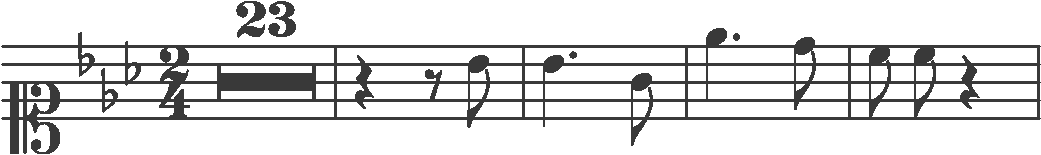

# Generated Input

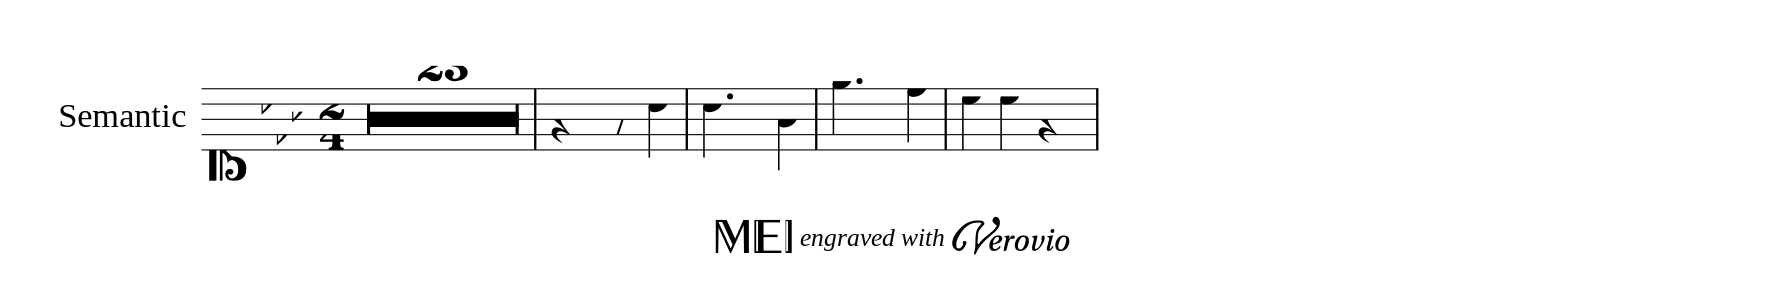

In [20]:
from google.colab.patches import cv2_imshow

show_markdown("# Actual Input")
cv2_imshow(cv2.imread(final_input_path))

show_markdown("# Generated Input")
show_svg_file(output_svg_path)

# Clean temporary files

In [21]:
del_temp_files(outputs_path + image_name)